Cleaning data

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

db=pd.read_csv("loan.csv",encoding= 'ISO-8859-1')
db=db.drop(columns=["last_credit_pull_d","next_pymnt_d","last_pymnt_d","id","member_id","Unnamed: 0","issue_d","zip_code","addr_state","earliest_cr_line"])
db["term"]=db["term"].str.replace("months","")
db["emp_length"]=db["emp_length"].str.replace("years","")
db["emp_length"]=db["emp_length"].str.replace("year","")
db["emp_length"]=db["emp_length"].str.replace("+","")
db["emp_length"]=db["emp_length"].str.replace("<","")
db["emp_length"]=db["emp_length"].str.replace(" 1","1")
db["verification_status"]=db["verification_status"].str.replace("Not Verified","0")
db["verification_status"]=db["verification_status"].str.replace("Verified","1")
db["verification_status"]=db["verification_status"].str.replace("Source Verified","1")
db["verification_status"]=db["verification_status"].str.replace("Source 1","1")
db["home_ownership"]=db["home_ownership"].str.replace("NONE","OTHER")
db["revol_util"]=db["revol_util"].str.replace("%","")
db["revol_util"]=db["revol_util"].str.replace("0.00","0.0")
db["revol_util"]=db["revol_util"].str.replace("100.00","100.0")

# print(db.head())
print(db["revol_util"])

0          0.0
1        21.30
2        99.90
3        47.20
4            0
         ...  
38475    73.50
38476    39.70
38477    62.20
38478    53.30
38479    62.60
Name: revol_util, Length: 38480, dtype: object


In [30]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
scalhome=OneHotEncoder(sparse_output=False)
db["mortgage"],db["other"],db["own"],db["rent"]=scalhome.fit_transform(db[["home_ownership"]]).T
db=db.drop(columns=["home_ownership"])

scaloanstatus=LabelEncoder()
scaloanpurpose=LabelEncoder()
db["loan_status"]=scaloanstatus.fit_transform(db[["loan_status"]])
db["purpose"]=scaloanpurpose.fit_transform(db[["purpose"]])
db["term"]=db["term"].astype(float)
db["emp_length"]=db["emp_length"].astype(float)
db["verification_status"]=db["verification_status"].astype(float)
db["revol_util"]=db["revol_util"].astype(float)
db=db.astype(float)
print(db.head())

   loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0        0.0          0.0              0.0  36.0      0.00         0.00   
1     2500.0       2500.0           2500.0  36.0     13.98        85.42   
2     5000.0       5000.0           5000.0  36.0     15.95       175.67   
3     7000.0       7000.0           7000.0  36.0      9.91       225.58   
4     2000.0       2000.0           2000.0  36.0      5.42        60.32   

   emp_length  annual_inc  verification_status  loan_status  ...  total_pymnt  \
0         1.0         0.0                  0.0          0.0  ...     0.000000   
1         4.0     20004.0                  0.0          4.0  ...  3075.291779   
2         4.0     59000.0                  0.0          0.0  ...  2948.760000   
3        10.0     53796.0                  0.0          5.0  ...  8082.391880   
4        10.0     30000.0                  0.0          5.0  ...  2161.663244   

   total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt

c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\stefa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
# print(db.isnull().sum()/len(db))
db["mths_since_last_delinq"]=db["mths_since_last_delinq"].fillna(db["mths_since_last_delinq"].mean())
db.dropna(inplace=True)
cor=db.corr().stack().reset_index()
cor.columns=["var1","var2","corr"]
cor=cor[cor["var1"]=="repay_fail"]
print(cor.query(f"corr>{0.2} or corr<{-0.2}"))

           var1             var2      corr
754  repay_fail         int_rate  0.202191
759  repay_fail      loan_status -0.904040
770  repay_fail      total_pymnt -0.245932
771  repay_fail  total_pymnt_inv -0.243487
772  repay_fail  total_rec_prncp -0.342441
774  repay_fail  last_pymnt_amnt -0.219397
775  repay_fail       repay_fail  1.000000


In [32]:
scalernontarget=MinMaxScaler()
scalertarget=MinMaxScaler()
colonnenontarget=(db.drop(columns=["repay_fail"]).values.reshape(-1,29))[1:]
colonnetarget=db["repay_fail"].values.reshape(-1,1)[1:]
x=scalernontarget.fit_transform(colonnenontarget)
y=scalertarget.fit_transform(colonnetarget)
y=y.reshape(37425)
print(y.shape)



(37425,)


<Axes: >

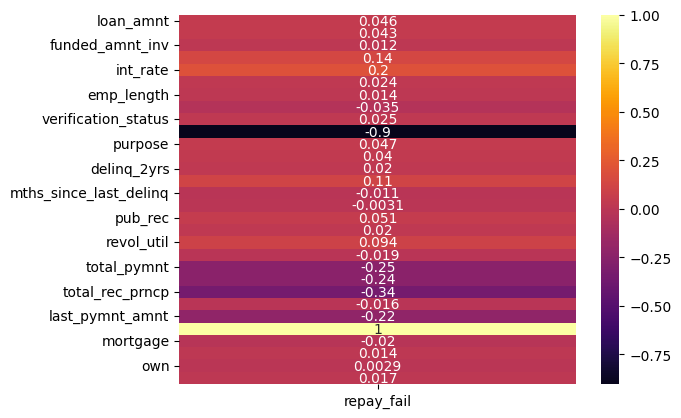

In [33]:
sns.heatmap(db.corr()[["repay_fail"]],annot=True, cmap="inferno",center=0)

In [34]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,r2_score
model=LogisticRegression()
# result=cross_validate(model,x,y,cv=10)
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.7,random_state=0)
model.fit(xtrain,ytrain)
pred=model.predict(xtest)
print(accuracy_score(ytest,pred))
# print(result["test_score"].mean())

0.9934983968649804


In [35]:
print(xtest[0])

[0.79710145 0.79710145 0.79214286 1.         0.38897806 0.47846486
 0.33333333 0.01885663 1.         0.125      0.30769231 0.22207402
 0.         0.         0.29174872 0.10869565 0.         0.00547559
 0.28823529 0.07865169 0.59458712 0.58874938 0.71196388 0.4193985
 0.01751783 1.         0.         0.         0.        ]
